# 🧠 Imports


In [1]:
import sys
from pathlib import Path
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# 📚 Imports modules perso
project_root = Path().resolve().parent
sys.path.append(str(project_root / "src/image_classification"))

from transforms_image import get_image_classification_transforms
from visualization_image import denormalize
from loader_image import get_filtered_dataloader
from plot_training_history import plot_training_history 
from plot_confusion_matrix import plot_confusion_matrix
from cnn_baseline import CNNBaseline
from train_image_classifier import train_model
from get_pretrained_vgg import get_pretrained_vgg


### 📸 Sélection aléatoire d'une image


In [2]:
folder_path = Path("../data/ImagensTCCRotuladas/Treino/Ervas")  # Change classe ici si besoin
image_paths = list(folder_path.glob("*.jpg"))
img_path = random.choice(image_paths)

img_raw = Image.open(img_path).convert("RGB")

### 🔁 Appliquer transforms


In [3]:
transform = get_image_classification_transforms(image_size=(128, 128))
img_tensor = transform(img_raw)

### 🖼️ Affichage

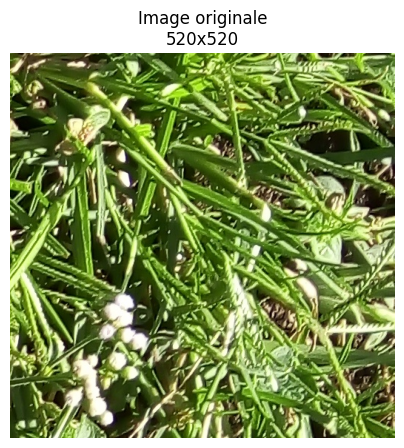

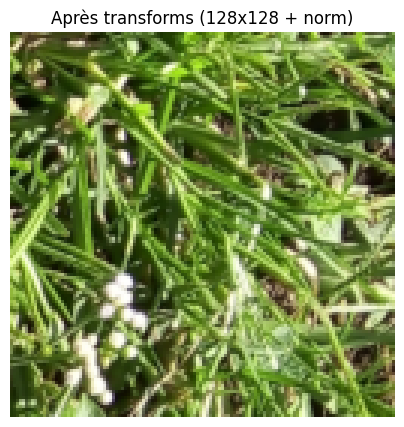

📐 Format tensor transformé : torch.Size([3, 128, 128])
📄 Image affichée : Imagem_03287_D3.jpg


In [4]:
# ============================
# 🖼️ Affichage image originale (brut)
# ============================
plt.figure(figsize=(5, 5))
plt.imshow(img_raw)
plt.title(f"Image originale\n{img_raw.size[0]}x{img_raw.size[1]}")
plt.axis("off")
plt.show()


# ============================
# 🎨 Dénormaliser pour affichage
# ============================
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img_denorm = denormalize(img_tensor.clone(), mean, std)

# ============================
# 🖼️ Affichage transformée
# ============================
plt.figure(figsize=(5, 5))
plt.imshow(img_denorm.permute(1, 2, 0))
plt.title("Après transforms (128x128 + norm)")
plt.axis("off")
plt.show()

# ============================
# 🧾 Format Tensor final
# ============================
print("📐 Format tensor transformé :", img_tensor.shape)
print("📄 Image affichée :", img_path.name)

# 📦 Chargement des données – 3 et 4 classes

Charge les datasets d'entraînement et de validation pour deux configurations :

- **3 classes** : `"Chao"`, `"Ervas"`, `"Milho"`
- **4 classes** : ajout de la classe `"Milho_ervas"`

Chaque classe est limitée à 50 images max pour équilibrer l’entraînement. Ces DataLoader sont utilisés dans les expériences avec les modèles `CNNBaseline` et `VGG16`.


In [5]:
train_loader, class_names = get_filtered_dataloader(
    root_dir="../data/ImagensTCCRotuladas/Treino",
    selected_classes=["Chao", "Ervas", "Milho"],
    max_images_per_class=50
)

val_loader, _ = get_filtered_dataloader(
    root_dir="../data/ImagensTCCRotuladas/Validação",
    selected_classes=["Chao", "Ervas", "Milho"],
    max_images_per_class=50
)


In [6]:
selected_classes = ["Chao", "Ervas", "Milho", "Milho_ervas"]

train_loader_4_classes, class_names_4_classes = get_filtered_dataloader(
    root_dir="../data/ImagensTCCRotuladas/Treino",
    selected_classes=selected_classes,
    max_images_per_class=50
)

val_loader_4_classes, _ = get_filtered_dataloader(
    root_dir="../data/ImagensTCCRotuladas/Validação",
    selected_classes=selected_classes,
    max_images_per_class=50
)


# 📦 Chargement du DataLoader (3 classes sélectionnées)

### 🔍 Test du modèle CNNBaseline sur un batch

Permet de :

- Charger un modèle `CNNBaseline` adapté au nombre de classes
- Récupérer un batch d’images depuis le `train_loader`
- Passer ces images dans le modèle pour obtenir des prédictions
- Comparer les prédictions aux vraies étiquettes

Cela sert à valider rapidement la structure du modèle et le format des sorties avant entraînement.


In [7]:
# 🧠 Charger le modèle
model = CNNBaseline(num_classes=len(class_names))

# 📤 Récupérer un batch
images, labels = next(iter(train_loader))
print("✅ Batch images :", images.shape)     # [B, 3, 128, 128]
print("✅ Batch labels :", labels.shape)     # [B]

# 🔁 Passage dans le modèle
outputs = model(images)
print("📐 Sortie logits :", outputs.shape)   # [B, num_classes]

# 🔢 Prédictions
_, preds = torch.max(outputs, 1)
print("🔮 Prédictions :", preds)
print("🎯 Vraies classes :", labels)


✅ Batch images : torch.Size([16, 3, 128, 128])
✅ Batch labels : torch.Size([16])
📐 Sortie logits : torch.Size([16, 3])
🔮 Prédictions : tensor([1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1])
🎯 Vraies classes : tensor([0, 2, 2, 2, 1, 2, 2, 0, 2, 2, 1, 0, 2, 2, 1, 2])


### 🖼️ Affichage d'une image prédite

Affiche une image issue du batch avec sa classe prédite et sa vraie étiquette.  
L’image est d’abord dénormalisée pour retrouver ses couleurs d’origine (valeurs RGB dans [0,1]).


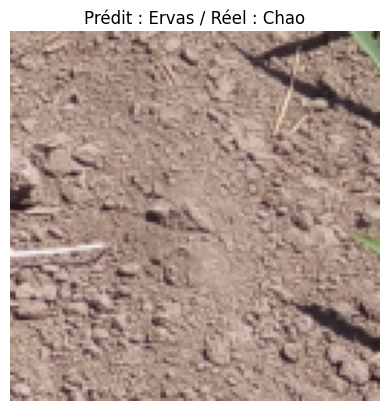

In [8]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

img = denormalize(images[0].clone(), mean, std)
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Prédit : {class_names[preds[0]]} / Réel : {class_names[labels[0]]}")
plt.axis("off")
plt.show()


## 🚀 Entraînement CNNBaseline (3 classes)

Entraînement du modèle CNNBaseline sur 3 classes avec Adam pendant 10 époques.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNBaseline(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

history = train_model(model, train_loader=train_loader, val_loader=val_loader,
                      criterion=criterion, optimizer=optimizer, 
                      device=device, epochs=10)



Epoch 1/10
Train Loss: 13.2301 | Train Acc: 0.4467 | Val Acc: 0.5867

Epoch 2/10
Train Loss: 2.1560 | Train Acc: 0.6400 | Val Acc: 0.5600

Epoch 3/10
Train Loss: 1.1689 | Train Acc: 0.6667 | Val Acc: 0.5467

Epoch 4/10
Train Loss: 1.0856 | Train Acc: 0.7133 | Val Acc: 0.5867

Epoch 5/10
Train Loss: 0.6110 | Train Acc: 0.8200 | Val Acc: 0.5933

Epoch 6/10
Train Loss: 0.4743 | Train Acc: 0.8333 | Val Acc: 0.3933

Epoch 7/10
Train Loss: 0.2024 | Train Acc: 0.9133 | Val Acc: 0.5867

Epoch 8/10
Train Loss: 0.3327 | Train Acc: 0.8667 | Val Acc: 0.5667

Epoch 9/10
Train Loss: 0.4158 | Train Acc: 0.8733 | Val Acc: 0.6267

Epoch 10/10
Train Loss: 0.5037 | Train Acc: 0.8600 | Val Acc: 0.5533


### 📊 Courbes et matrice de confusion CNN (3 classes)

Affichage de l’évolution de l’accuracy et du loss, ainsi que de la matrice de confusion sur le jeu de validation.


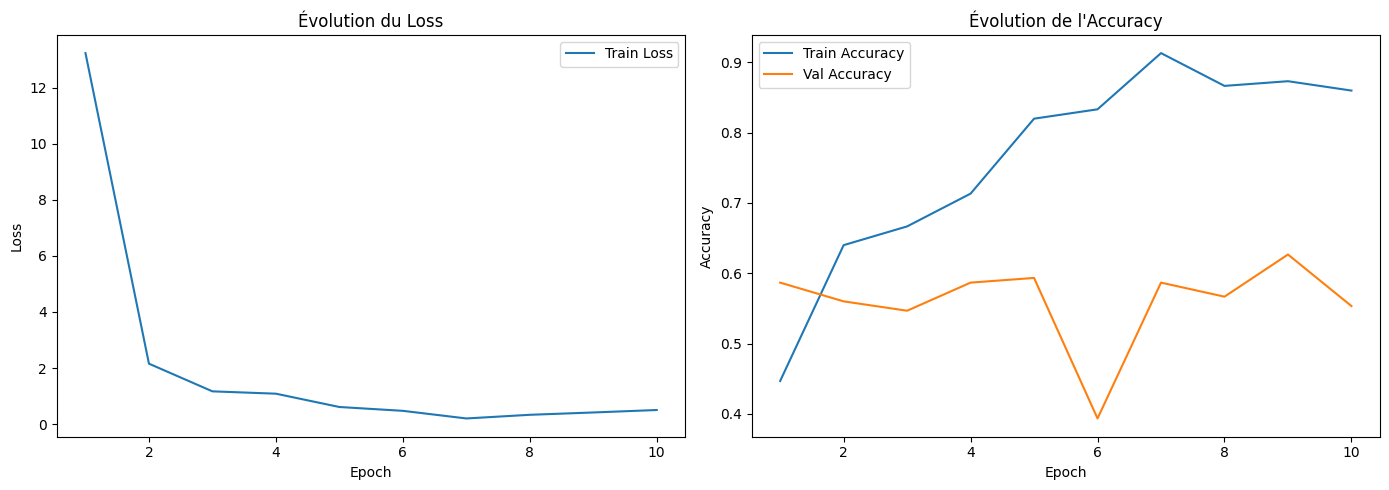

In [10]:
plot_training_history(history)



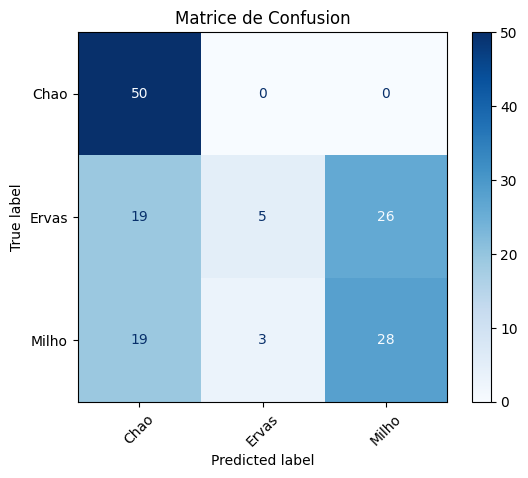

In [11]:
plot_confusion_matrix(model, val_loader, class_names, device)


## 🚀 Entraînement CNNBaseline (4 classes)

Entraînement du modèle CNNBaseline sur 4 classes avec Adam pendant 10 époques.


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_CNN_4_classes = CNNBaseline(num_classes=len(class_names_4_classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN_4_classes.parameters(), lr=1e-3)

history = train_model(model_CNN_4_classes,
                      train_loader=train_loader_4_classes,
                      val_loader=val_loader_4_classes,
                      criterion=criterion,
                      optimizer=optimizer,
                      device=device,
                      epochs=10)



Epoch 1/10
Train Loss: 9.1554 | Train Acc: 0.4050 | Val Acc: 0.4450

Epoch 2/10
Train Loss: 3.8015 | Train Acc: 0.4700 | Val Acc: 0.4200

Epoch 3/10
Train Loss: 2.2976 | Train Acc: 0.5450 | Val Acc: 0.4350

Epoch 4/10
Train Loss: 1.0388 | Train Acc: 0.7100 | Val Acc: 0.3900

Epoch 5/10
Train Loss: 0.6322 | Train Acc: 0.7450 | Val Acc: 0.4600

Epoch 6/10
Train Loss: 0.4716 | Train Acc: 0.8500 | Val Acc: 0.4500

Epoch 7/10
Train Loss: 0.3597 | Train Acc: 0.8850 | Val Acc: 0.4750

Epoch 8/10
Train Loss: 0.1921 | Train Acc: 0.9500 | Val Acc: 0.4750

Epoch 9/10
Train Loss: 0.1514 | Train Acc: 0.9650 | Val Acc: 0.4700

Epoch 10/10
Train Loss: 0.1107 | Train Acc: 0.9750 | Val Acc: 0.4450


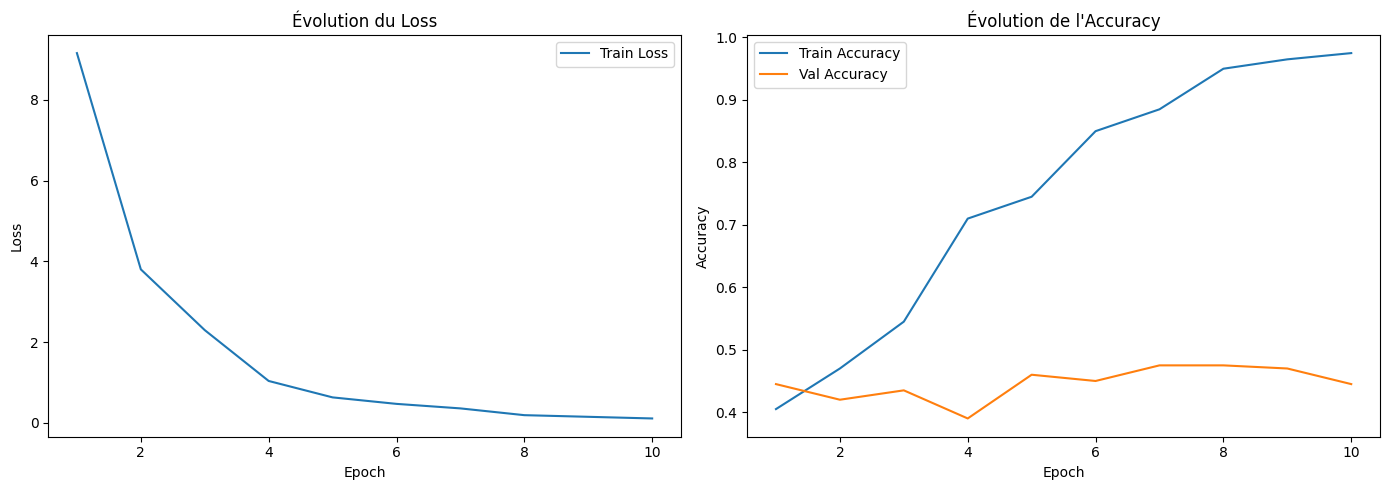

In [13]:
plot_training_history(history)


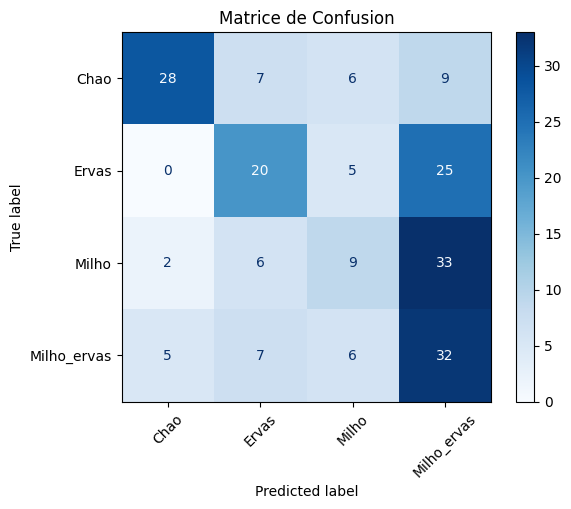

In [14]:
plot_confusion_matrix(model_CNN_4_classes, val_loader_4_classes, class_names_4_classes, device)


## 🧠 Initialisation VGG16 préentraîné (3 classes)

Chargement du modèle VGG16 avec fine-tuning du classifier pour 3 classes.  
Seules les couches finales sont entraînées (feature extraction activée).


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_VGG16 = get_pretrained_vgg(num_classes=len(class_names), feature_extract=True)
model_VGG16 = model_VGG16.to(device)

criterion = nn.CrossEntropyLoss()

# On n'entraîne que les paramètres non figés
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_VGG16.parameters()), lr=1e-3)


### 🚀 Entraînement VGG16 (3 classes)

Entraînement du modèle VGG16 préentraîné sur 3 classes pendant 10 époques.


In [16]:
history = train_model(
            model_VGG16,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            epochs=10
         )


Epoch 1/10
Train Loss: 0.8695 | Train Acc: 0.5933 | Val Acc: 0.7867

Epoch 2/10
Train Loss: 0.5288 | Train Acc: 0.7800 | Val Acc: 0.8400

Epoch 3/10
Train Loss: 0.3910 | Train Acc: 0.8133 | Val Acc: 0.8533

Epoch 4/10
Train Loss: 0.3118 | Train Acc: 0.8733 | Val Acc: 0.8667

Epoch 5/10
Train Loss: 0.2899 | Train Acc: 0.8733 | Val Acc: 0.8600

Epoch 6/10
Train Loss: 0.2550 | Train Acc: 0.9067 | Val Acc: 0.8600

Epoch 7/10
Train Loss: 0.2282 | Train Acc: 0.9400 | Val Acc: 0.8667

Epoch 8/10
Train Loss: 0.2121 | Train Acc: 0.9333 | Val Acc: 0.8600

Epoch 9/10
Train Loss: 0.2013 | Train Acc: 0.9333 | Val Acc: 0.8600

Epoch 10/10
Train Loss: 0.1945 | Train Acc: 0.9333 | Val Acc: 0.8467


### 📊 Courbes et matrice de confusion – VGG16 (3 classes)

Affichage des performances du modèle VGG16 sur le jeu de validation à 3 classes.


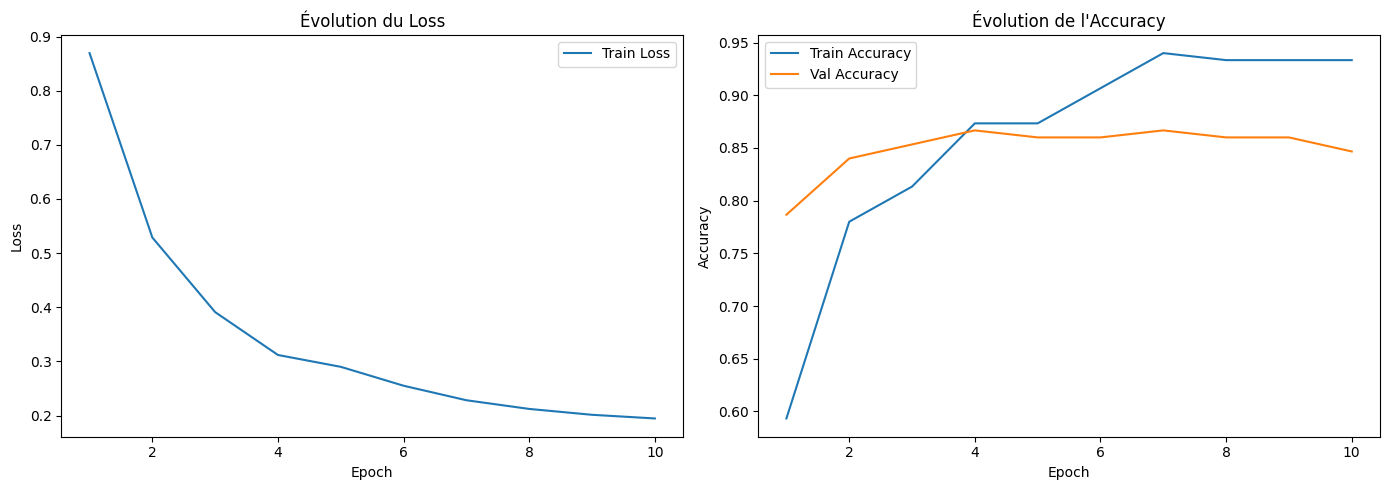

In [17]:
plot_training_history(history)


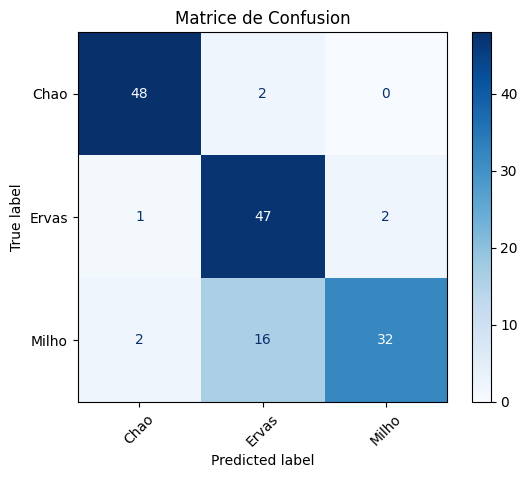

In [18]:
plot_confusion_matrix(model_VGG16, val_loader, class_names, device)


## 🚀 Entraînement VGG16 (4 classes)

Entraînement du modèle VGG16 préentraîné sur 4 classes pendant 10 époques.

In [19]:
model_VGG16_4_classes = get_pretrained_vgg(num_classes=len(class_names_4_classes), feature_extract=True)
model_VGG16_4_classes = model_VGG16_4_classes.to(device)

criterion_VGG16_4_classes = nn.CrossEntropyLoss()
optimizer_VGG16_4_classes = optim.Adam(
    filter(lambda p: p.requires_grad, model_VGG16_4_classes.parameters()),
    lr=1e-3
)


In [20]:
history_VGG16_4_classes = train_model(
    model_VGG16_4_classes,
    train_loader=train_loader_4_classes,
    val_loader=val_loader_4_classes,
    criterion=criterion_VGG16_4_classes,
    optimizer=optimizer_VGG16_4_classes,
    device=device,
    epochs=10
)



Epoch 1/10
Train Loss: 1.2813 | Train Acc: 0.4350 | Val Acc: 0.6400

Epoch 2/10
Train Loss: 0.7533 | Train Acc: 0.6950 | Val Acc: 0.6950

Epoch 3/10
Train Loss: 0.5800 | Train Acc: 0.7750 | Val Acc: 0.6650

Epoch 4/10
Train Loss: 0.5562 | Train Acc: 0.7900 | Val Acc: 0.6650

Epoch 5/10
Train Loss: 0.4901 | Train Acc: 0.7950 | Val Acc: 0.7000

Epoch 6/10
Train Loss: 0.3860 | Train Acc: 0.8450 | Val Acc: 0.7000

Epoch 7/10
Train Loss: 0.3894 | Train Acc: 0.8750 | Val Acc: 0.6750

Epoch 8/10
Train Loss: 0.3401 | Train Acc: 0.8750 | Val Acc: 0.6850

Epoch 9/10
Train Loss: 0.3569 | Train Acc: 0.8550 | Val Acc: 0.6950

Epoch 10/10
Train Loss: 0.3182 | Train Acc: 0.8700 | Val Acc: 0.6850


### 📊 Courbes et matrice de confusion – VGG16 (4 classes)

Affichage des performances du modèle VGG16 sur le jeu de validation à 4 classes.


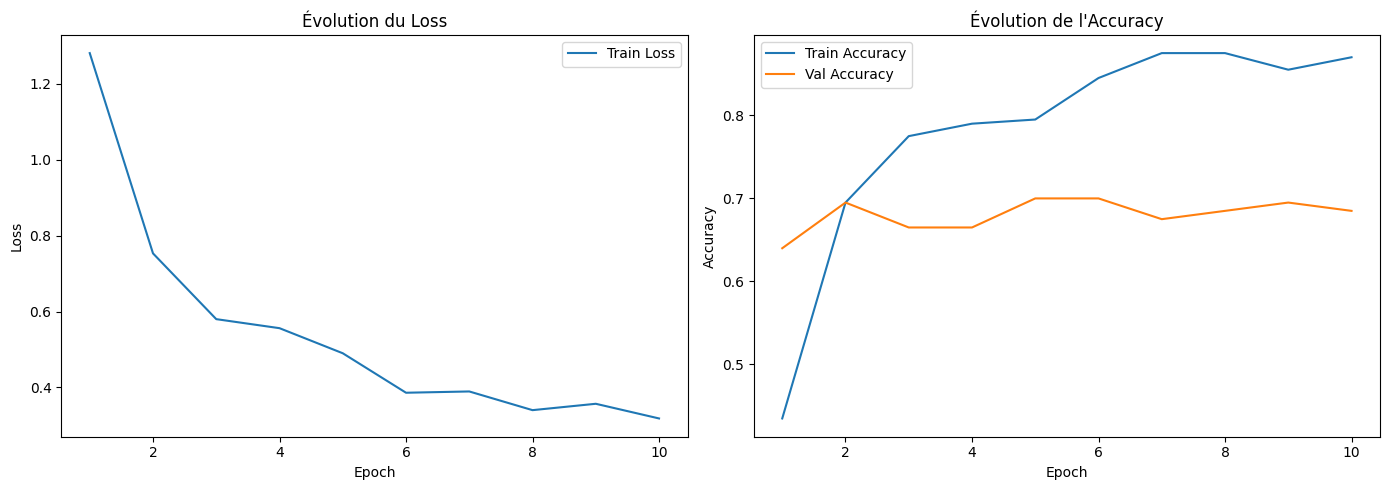

In [21]:
plot_training_history(history_VGG16_4_classes)


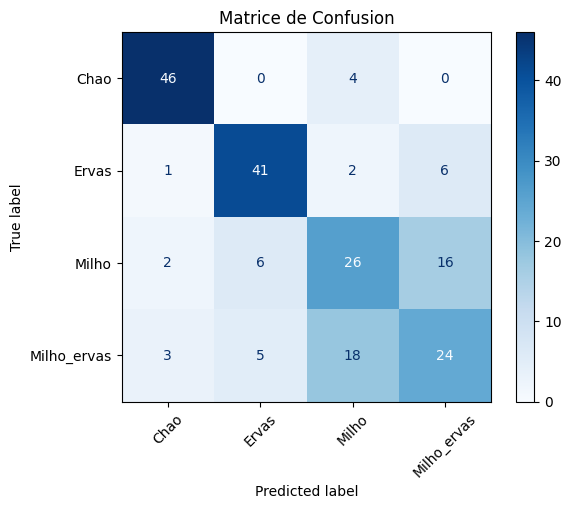

In [22]:
plot_confusion_matrix(model_VGG16_4_classes, val_loader_4_classes, class_names_4_classes, device)
